In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# 设置字体为 SimHei（黑体），或者其他支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

In [3]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [4]:
sheet = pd.read_excel('data_input/FU-SC.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')
last_day = sheet['FU-7.33*SC（期货指数）拟合残差/新加坡高硫燃料油380裂解价差'].last_valid_index()
 
future_data_30days = sheet[sheet.index > last_day]
target_days = pd.date_range(start=last_day+ pd.DateOffset(1), periods=21, freq='B')
target_end = target_days[-1]
new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='B')
sheet = sheet.reindex(sheet.index.union(new_index))
sheet = sheet[sheet.index <= target_end]

sheet.tail()

,新加坡高硫燃料油380裂解价差,FU-7.33*SC（期货指数）,FU-7.33*SC（期货指数）拟合残差/新加坡高硫燃料油380裂解价差,山东柴油裂解差,人民币汇率收盘价,柴油出口利润（华东-新加坡）
2025-12-02,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-03,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-04,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-05,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-08,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
sheet.columns

Index(['新加坡高硫燃料油380裂解价差', 'FU-7.33*SC（期货指数）',
       'FU-7.33*SC（期货指数）拟合残差/新加坡高硫燃料油380裂解价差', '山东柴油裂解差', '人民币汇率收盘价',
       '柴油出口利润（华东-新加坡）'],
      dtype='object')

In [6]:
sheet4 = pd.ExcelFile('eta/山东柴油裂解差(多因子)_合并数据.xlsx').parse('Sheet1')
sheet4['Date'] = pd.to_datetime(sheet4['Date'], errors='coerce')
sheet4 = sheet4.sort_values('Date', ascending=True)
sheet4 = sheet4.drop(columns=['真实值'])
sheet4 = sheet4.dropna()
sheet4.head()

,Date,预测值
19,2025-11-10,622.9
18,2025-11-11,585.9
17,2025-11-12,604.8
16,2025-11-13,549.8
15,2025-11-14,574.2


In [7]:
sheet2 = pd.ExcelFile('eta/柴油出口利润-华东-新加坡_合并数据.xlsx').parse('Sheet1')
sheet2['Date'] = pd.to_datetime(sheet2['Date'], errors='coerce')
sheet2 = sheet2.sort_values('Date', ascending=True)
sheet2 = sheet2.drop(columns=['真实值'])
sheet2 = sheet2.dropna()
sheet2.head()

,Date,预测值
19,2025-11-07,324.5
18,2025-11-10,289.9
17,2025-11-11,268.7
16,2025-11-12,260.0
15,2025-11-13,332.1


In [8]:
# 合并 sheet1 和 sheet2 的数据到 sheet
sheet_daily = sheet.copy()
sheet_daily.index.name = 'Date'
sheet_daily = sheet_daily.reset_index()

# 合并 sheet1 的美国10年通胀预期数据

sheet_daily = pd.merge(
    sheet_daily,
    sheet2[['Date', '预测值']],
    on='Date',
    how='left'
)
sheet_daily['柴油出口利润（华东-新加坡）'] = sheet_daily['柴油出口利润（华东-新加坡）'].fillna(sheet_daily['预测值'])
sheet_daily = sheet_daily.drop(columns=['预测值'])



sheet_daily = pd.merge(
    sheet_daily,
    sheet4[['Date', '预测值']],
    on='Date',
    how='left'
)
sheet_daily['山东柴油裂解差'] = sheet_daily['山东柴油裂解差'].fillna(sheet_daily['预测值'])
sheet_daily = sheet_daily.drop(columns=['预测值'])

# 将 sheet_daily 重新赋值给 sheet
sheet = sheet_daily.copy()
sheet = sheet.set_index('Date')

In [9]:
################################# 处理缺失值 #################################
fill_methods = {
'山东柴油裂解差': 'interpolate', 
'人民币汇率收盘价': 'interpolate',
'柴油出口利润（华东-新加坡）': 'interpolate'
} 
sheet= fill_missing_values(sheet, fill_methods, return_only_filled=False)
#sheet.loc[:last_day, '汽油出口利润（华东-新加坡）'] = sheet.loc[:last_day, '汽油出口利润（华东-新加坡）'].interpolate(method='linear')

#################################  因子处理  #################################

sheet['山东柴油裂解差_提前5天'] = sheet['山东柴油裂解差'].shift(5)
sheet['人民币汇率收盘价_提前20天'] = sheet['人民币汇率收盘价'].shift(20)
sheet['柴油出口利润（华东-新加坡）_提前5天'] = sheet['柴油出口利润（华东-新加坡）'].shift(5)

sheet['柴油出口利润（华东-新加坡）_提前5天_逆序'] = reverse_column(sheet, '柴油出口利润（华东-新加坡）_提前5天')
sheet['人民币汇率收盘价_提前20天_逆序'] = reverse_column(sheet, '人民币汇率收盘价_提前20天')


# 获取最后20个数据点
last_20_points = sheet.tail(20)

# 处理每一列
for col in ['柴油出口利润（华东-新加坡）_提前5天_逆序', '山东柴油裂解差_提前5天']:
    # 找出重复值
    duplicates = last_20_points[col][last_20_points[col].duplicated(keep='first')]
    # 如果重复值超过3个,保留第一个出现的值,其他置为空
    if len(duplicates) >= 3:
        sheet.loc[sheet.index[-20:], col] = sheet.loc[sheet.index[-20:], col].mask(
            lambda x: x.duplicated(keep='first')
        )

sheet[['柴油出口利润（华东-新加坡）_提前5天_逆序', '山东柴油裂解差_提前5天']]
################################# 数据筛选  #################################

sheet_daily = sheet.reset_index().rename(columns={'index': 'Date'})
sheet_daily['Date'] = pd.to_datetime(sheet_daily['Date'])

sheet_daily = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2020-01-01')]

sheet_daily = sheet_daily.reset_index(drop=True)
sheet_daily = sheet_daily[
    (sheet_daily['Date'] > last_day) | 
    (sheet_daily['FU-7.33*SC（期货指数）拟合残差/新加坡高硫燃料油380裂解价差'].notna())
]

################################# 数据 读取-处理 结束 #################################

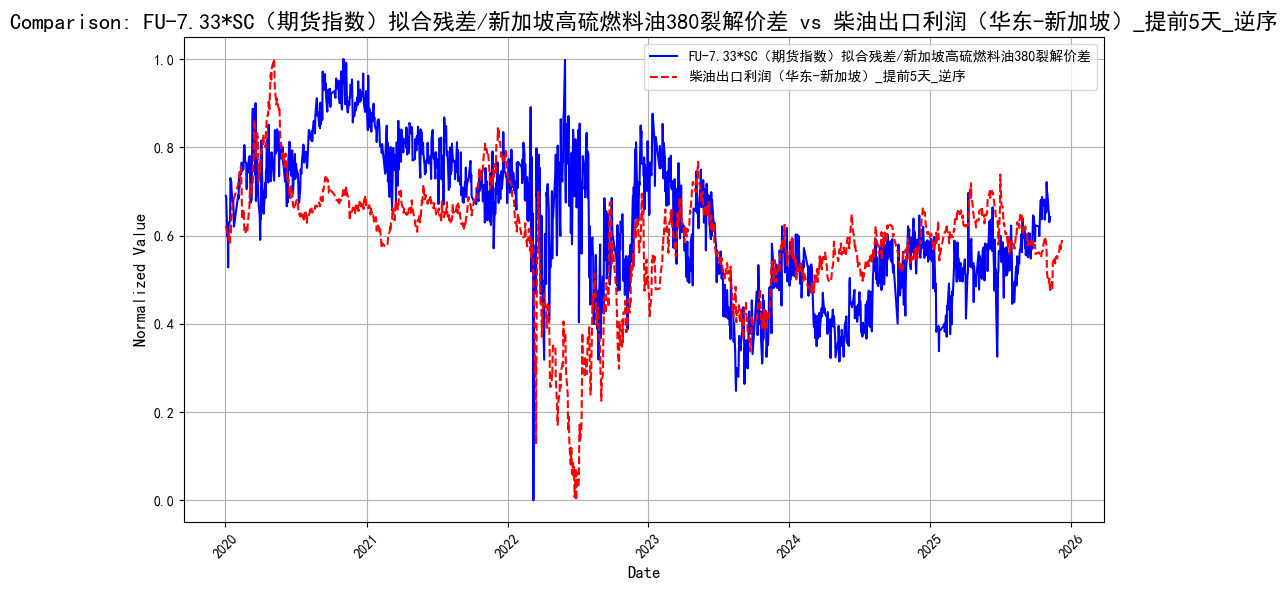

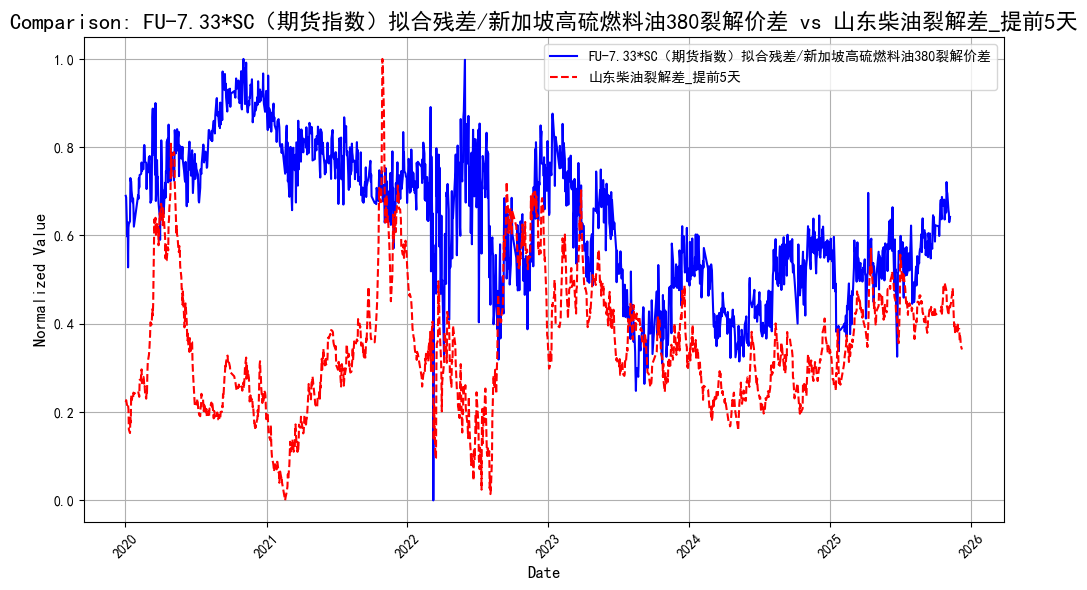

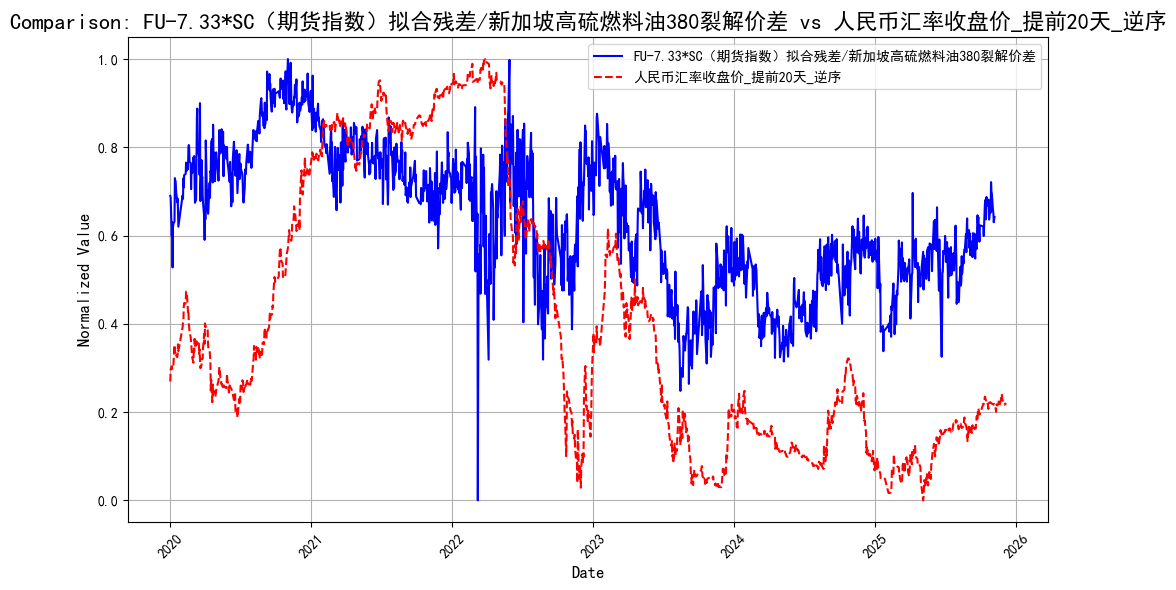

In [10]:
sheet_daily_plot = sheet_daily.set_index('Date')
plot_comparison_multiple(
    sheet_daily_plot, 
    main_col='FU-7.33*SC（期货指数）拟合残差/新加坡高硫燃料油380裂解价差', 
    compare_cols=[
        '柴油出口利润（华东-新加坡）_提前5天_逆序',
        '山东柴油裂解差_提前5天',
        '人民币汇率收盘价_提前20天_逆序'
        ]
)

In [11]:
################################# 划分 数据 训练 测试 预测 #################################
# 划分训练集、测试集和未来数据、设置测试集长度
train_data = sheet_daily[sheet_daily['Date'] <= last_day].copy()
test_period = 60
test_data = train_data[-test_period:].copy() 
train_data = train_data[:-test_period].copy()
future_data = sheet_daily[sheet_daily['Date'] > last_day].copy()

feature_columns = [
    '柴油出口利润（华东-新加坡）_提前5天_逆序',
    '山东柴油裂解差_提前5天',
    '人民币汇率收盘价_提前20天_逆序'
]

predict_column = 'FU-7.33*SC（期货指数）拟合残差/新加坡高硫燃料油380裂解价差'

X_train = train_data[feature_columns]
y_train = train_data[predict_column]

X_test = test_data[feature_columns]
y_test = test_data[predict_column]

X_future = future_data[feature_columns]

################################# Xgboost 模型 训练 测试 预测 #################################

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_future_scaled = scaler.transform(X_future)

train_dmatrix_huber = xgb.DMatrix(X_train_scaled, label=y_train)
train_dmatrix_zscore = xgb.DMatrix(X_train_scaled, label=y_train)
test_dmatrix = xgb.DMatrix(X_test_scaled, label=y_test)
future_dmatrix = xgb.DMatrix(X_future_scaled)

# 计算样本权重 - 使用Huber损失函数的思想降低异常值影响
residuals = np.abs(y_train - y_train.mean())
delta = np.percentile(residuals, 90)  # 使用90%分位数作为阈值
sample_weights_huber = np.where(residuals <= delta, 1.0, delta/residuals)
train_dmatrix_huber.set_weight(sample_weights_huber)

# 使用z-score思路计算样本权重
z_scores = np.abs((y_train - y_train.mean()) / y_train.std())
z_threshold = 2.0  # 设置z-score阈值为2个标准差
sample_weights_zscore = np.where(z_scores <= z_threshold, 1.0, z_threshold/z_scores)
train_dmatrix_zscore.set_weight(sample_weights_zscore)

# 设置XGBoost参数
params = {
    'objective': 'reg:squarederror',  # 回归任务
    'learning_rate': 0.01,  # 默认学习率
    'max_depth': 15,  # 默认树深度
    'min_child_weight': 1,  # 默认最小子节点权重
    'subsample': 0.9,  # 默认子采样比例
    'colsample_bytree': 0.9,  # 默认特征采样比例
    'gamma': 1,  # 默认最小分裂损失
    'reg_alpha': 0,  # 默认L1正则化
    'reg_lambda': 2,  # 默认L2正则化
    'eval_metric': 'rmse',  # 评估指标
    'seed': 42,  # 随机种子
#    'tree_method': 'auto'  # 默认树方法
}


num_boost_round = 3000
evals_result = {}

# 模型训练
model = xgb.train(
    params,
    train_dmatrix_huber,  # 使用带权重的DMatrix
    num_boost_round, # 训练最大轮数
    evals=[(test_dmatrix, 'eval'), (train_dmatrix_huber, 'train')],  # 更新评估数据集
    early_stopping_rounds=100,  # 早停策略：若连续50轮验证集的误差没有改善，则停止训练
    evals_result=evals_result,  # 保存训练过程中的评估结果
    verbose_eval=500 # 每100轮输出一次评估信息
)


y_train_pred_dmatrix = model.predict(train_dmatrix_huber)
y_test_pred_dmatrix = model.predict(test_dmatrix)

train_mse = mean_squared_error(y_train, y_train_pred_dmatrix)
test_mse = mean_squared_error(y_test, y_test_pred_dmatrix)
train_r2 = r2_score(y_train, y_train_pred_dmatrix)
test_r2 = r2_score(y_test, y_test_pred_dmatrix)
print(f"训练集 MSE (DMatrix): {round(train_mse, 4)}, 训练集 R² (DMatrix): {round(train_r2, 4)}")
print(f"测试集 MSE (DMatrix): {round(test_mse, 4)}, 测试集 R² (DMatrix): {round(test_r2, 4)}")

##### 预测未来 非全部数据 和 结果存储（y_test,y_future） #####
y_future_pred_dmatrix = model.predict(future_dmatrix)
test_data.loc[:, '预测值'] = y_test_pred_dmatrix
future_data.loc[:, '预测值'] = y_future_pred_dmatrix

[0]	eval-rmse:93.76970	train-rmse:239.28416


[500]	eval-rmse:109.14062	train-rmse:26.33668


[1000]	eval-rmse:114.07696	train-rmse:10.14119


[1500]	eval-rmse:114.84765	train-rmse:5.44551


[2000]	eval-rmse:115.15229	train-rmse:3.25486


[2500]	eval-rmse:115.34687	train-rmse:2.31187


[2999]	eval-rmse:115.38928	train-rmse:1.97387


训练集 MSE (DMatrix): 5.0193, 训练集 R² (DMatrix): 0.9999
测试集 MSE (DMatrix): 13314.6867, 测试集 R² (DMatrix): -0.9349


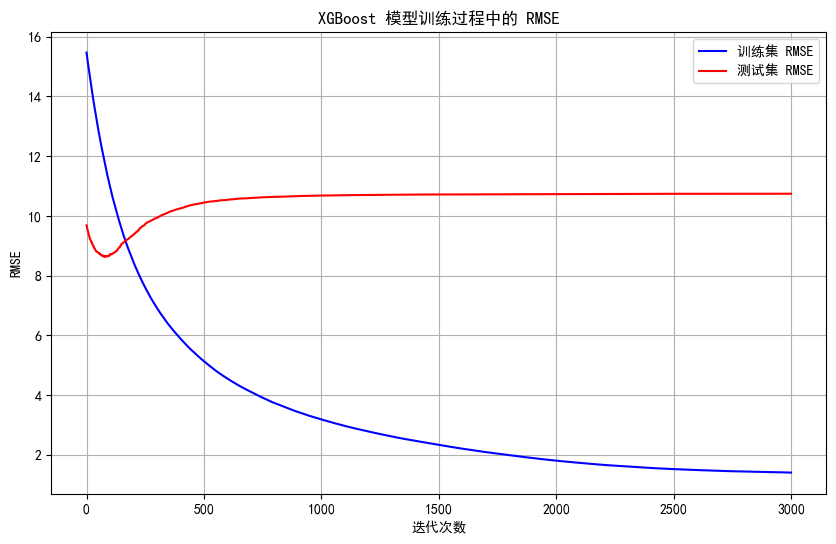

In [12]:
# 可视化训练过程中的评估指标
plt.figure(figsize=(10, 6))
train_rmse = np.sqrt(evals_result['train']['rmse'])
test_rmse = np.sqrt(evals_result['eval']['rmse'])

epochs = len(train_rmse)
x_axis = range(epochs)

plt.plot(x_axis, train_rmse, label='训练集 RMSE', color='blue')
plt.plot(x_axis, test_rmse, label='测试集 RMSE', color='red')

plt.xlabel('迭代次数')
plt.ylabel('RMSE')
plt.title('XGBoost 模型训练过程中的 RMSE')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
################################# Xgboost 模型 训练 测试 预测 所有数据 #################################
X_all = pd.concat([X_train, X_test]).reset_index(drop=True)
y_all = pd.concat([y_train, y_test]).reset_index(drop=True)

X_all_scaled = scaler.transform(X_all)
X_future_scaled = scaler.transform(X_future)

# 创建 DMatrix 对象
all_data_dmatrix = xgb.DMatrix(X_all_scaled, label=y_all)
future_dmatrix_all = xgb.DMatrix(X_future_scaled)

# 计算所有数据的样本权重
residuals_all = np.abs(y_all - y_all.mean())
sample_weights_all = np.where(residuals_all <= delta, 1.0, delta / residuals_all)

all_data_dmatrix.set_weight(sample_weights_all)  # 加入样本权重

# 训练模型
model_all = xgb.train(
    params,
    all_data_dmatrix,
    num_boost_round,
    evals=[(all_data_dmatrix, 'train')],
    early_stopping_rounds=100,
    evals_result=evals_result,
    verbose_eval=500
)

y_all_pred = model_all.predict(all_data_dmatrix)
y_future_pred_all = model_all.predict(future_dmatrix_all)

all_mse = mean_squared_error(y_all, y_all_pred)
all_r2 = r2_score(y_all, y_all_pred)

print(f"全部数据 MSE: {round(all_mse, 4)}, 全部数据 R²: {round(all_r2, 4)}")

# 存储全部数据的预测结果
all_data = pd.concat([train_data, test_data]).reset_index(drop=True)
all_data.loc[:, '预测值_全量'] = y_all_pred
future_data.loc[:, '预测值_全量'] = y_future_pred_all

[0]	train-rmse:234.90294


[500]	train-rmse:26.38898


[1000]	train-rmse:10.22778


[1500]	train-rmse:5.34059


[2000]	train-rmse:3.07407


[2500]	train-rmse:2.08131


[2999]	train-rmse:1.72825


全部数据 MSE: 3.8718, 全部数据 R²: 0.9999


Gap between last actual value and first prediction: 9.80205965423584


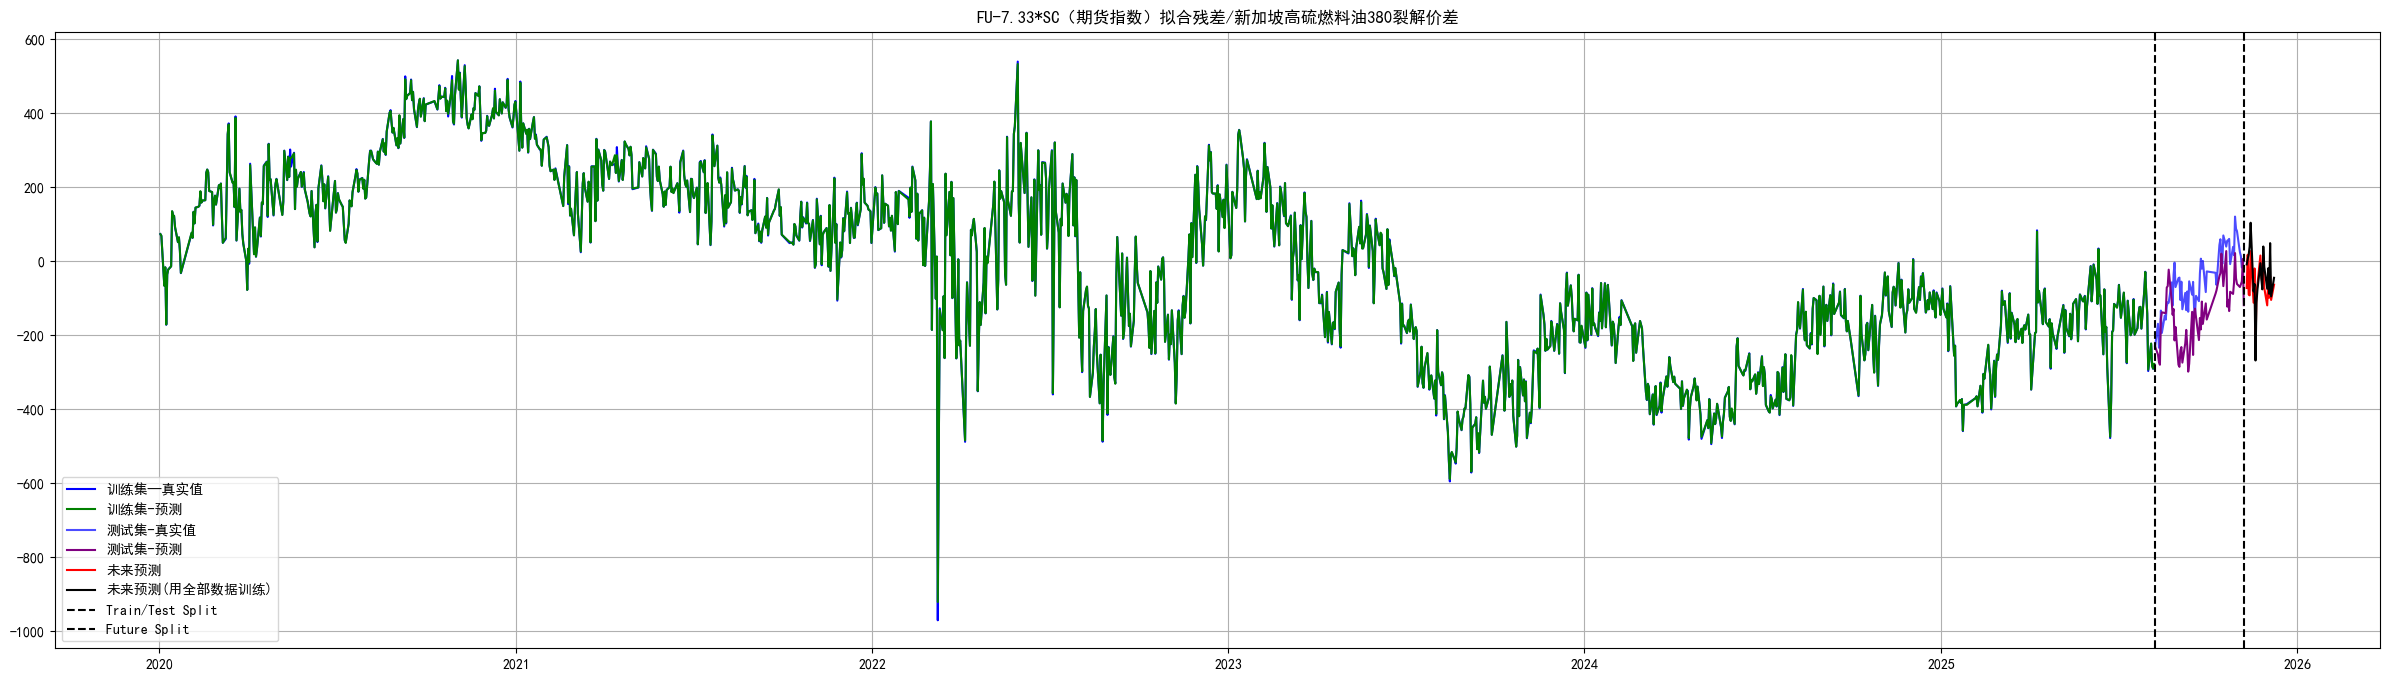

In [14]:
plt.figure(figsize=(30, 8))
# 绘制主要数据
future_data = plot_predictions(y_test, future_data, col=True, label=True)
plt.plot(train_data['Date'], y_train, label='训练集—真实值', color='blue')
plt.plot(train_data['Date'], y_train_pred_dmatrix, label='训练集-预测', color='green')
plt.plot(test_data['Date'], y_test, label='测试集-真实值', color='blue', alpha=0.7)
plt.plot(test_data['Date'], y_test_pred_dmatrix, label='测试集-预测', color='purple')
plt.plot(future_data['Date'], future_data['预测值'], label='未来预测', color='red')
plt.plot(future_data['Date'], future_data['预测值_全量'], label='未来预测(用全部数据训练)', color='black')

# 添加分割线
plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')

# 设置标题和图例
plt.title('FU-7.33*SC（期货指数）拟合残差/新加坡高硫燃料油380裂解价差')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
################################# 训练预测数据 excel格式输出  #################################
'''
1. 日度数据 （真实值 和 预测值）
2. 月度数据 （真实值、训练值、预测值）
'''

############ 日度 数据 ############
# 创建日度数据框
historical_actual_daily = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 只保留2023年之后的数据
historical_actual_daily = historical_actual_daily[historical_actual_daily['Date'].dt.year >= 2023]
# 创建预测数据框
future_pred_daily = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})


merged_df_daily = pd.merge(historical_actual_daily, future_pred_daily, on='Date', how='outer')
merged_df_daily = merged_df_daily.sort_values('Date', ascending=False)
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
merged_df_daily.to_excel('eta/FU-SC拟合残差-新加坡高硫燃料油380裂解价差_合并数据.xlsx', index=False,float_format='%.1f')

merged_df_daily.head()

,Date,真实值,预测值
709,2025/12/08,NaN,-44.808315
708,2025/12/05,NaN,-95.078323
707,2025/12/04,NaN,48.824799
706,2025/12/03,NaN,-88.072403
705,2025/12/02,NaN,-19.178171


In [16]:
############ 月度 数据 ############
# 历史真实值
historical_actual_monthly = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 真实数据 只保留2023年之后的
historical_actual_monthly = historical_actual_monthly[historical_actual_monthly['Date'].dt.year >= 2023]
# 2024年及以后训练集预测值
train_pred_2024 = pd.DataFrame({
    'Date': train_data[train_data['Date'].dt.year >= 2024]['Date'],
    '预测值': y_train_pred_dmatrix[train_data['Date'].dt.year >= 2024]
})
# 2024年及以后c测试集集预测值
test_pred_2024 = test_data[['Date', '预测值']].copy()
# 未来预测值 
future_pred_2024 = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})
# 合并 训练集预测+测试集预测+未来预测
future_pred_monthly = pd.concat([
    train_pred_2024, 
    test_pred_2024, 
    future_pred_2024
    ], axis=0).sort_values('Date')

# 合并历史真实值和预测值
merged_df_monthly = pd.merge(historical_actual_monthly, future_pred_monthly, on='Date', how='outer')
merged_df_monthly.set_index('Date', inplace=True)
merged_df_monthly = merged_df_monthly.resample('ME').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
# 删除真实值和预测值都为空的行
merged_df_monthly = merged_df_monthly.dropna(subset=['真实值', '预测值'], how='all')
# 保存成excel
merged_df_monthly.to_excel('eta/FU-SC拟合残差-新加坡高硫燃料油380裂解价差_月度数据.xlsx', index=False, float_format='%.1f')
merged_df_monthly.head()

,Date,真实值,预测值
35,2025/12/31,NaN,-45.455063
34,2025/11/30,3.241180,-42.218460
33,2025/10/31,37.386265,-56.122116
32,2025/09/30,-74.598909,-201.413040
31,2025/08/31,-166.086843,-185.890411


In [17]:
sheet3 = pd.ExcelFile('eta/FU-SC拟合残差-新加坡高硫燃料油380裂解价差_合并数据.xlsx').parse('Sheet1')
sheet3['Date'] = pd.to_datetime(sheet3['Date'], errors='coerce')
sheet3 = sheet3.sort_values('Date', ascending=True)
sheet3 = sheet3.drop(columns=['真实值'])
sheet3 = sheet3.dropna()
sheet3.head()

,Date,预测值
20,2025-11-10,-8.5
19,2025-11-11,6.5
18,2025-11-12,17.5
17,2025-11-13,39.9
16,2025-11-14,103.9


In [18]:
# 尝试多个可能的文件路径
file_paths4 = [
    os.path.expanduser("~/Desktop/X-BASE/燃料油/eta/新加坡高硫燃料油380裂解价差_合并数据.xlsx"), 
    os.path.expanduser("~/Desktop/弘则研究/Horizon-Insights/X-base/燃料油/eta/新加坡高硫燃料油380裂解价差_合并数据.xlsx"),
    os.path.expanduser("~/Downloads/hongze/燃料油/eta/新加坡高硫燃料油380裂解价差_合并数据.xlsx")
]

file_path4 = None
for path4 in file_paths4:
    if os.path.isfile(path4):  # 确保是文件而不是目录
        file_path4 = path4
        break

if file_path4 is None:
    raise FileNotFoundError("未找到数据文件")

try:
    sheet4 = pd.read_excel(file_path4, sheet_name='Sheet1')
    sheet4['Date'] = pd.to_datetime(sheet4['Date'], errors='coerce')
    sheet4 = sheet4.drop(columns=['真实值'])
    sheet4 = sheet4.dropna()
    sheet4 = sheet4.sort_values('Date', ascending=True)
    sheet4.head()
except Exception as e:
    raise Exception(f"读取文件时出错: {str(e)}")

sheet4.head()

,Date,预测值
23,2025-11-09,-4.7
22,2025-11-10,-4.7
21,2025-11-11,-4.9
20,2025-11-12,-4.3
19,2025-11-13,-4.3


In [19]:
# 合并 sheet1 和 sheet2 的数据到 sheet
sheet_sum = sheet.copy()
sheet_sum.index.name = 'Date'
sheet_sum = sheet_sum.reset_index()


sheet_sum = pd.merge(
    sheet_sum,
    sheet4[['Date', '预测值']],
    on='Date',
    how='left'
)
sheet_sum['新加坡高硫燃料油380裂解价差'] = sheet_sum['新加坡高硫燃料油380裂解价差'].fillna(sheet_sum['预测值'])
sheet_sum = sheet_sum.drop(columns=['预测值'])

sheet_sum = pd.merge(
    sheet_sum,
    sheet3[['Date', '预测值']],
    on='Date',
    how='left'
)
sheet_sum['FU-7.33*SC（期货指数）拟合残差/新加坡高硫燃料油380裂解价差'] = sheet_sum['FU-7.33*SC（期货指数）拟合残差/新加坡高硫燃料油380裂解价差'].fillna(sheet_sum['预测值'])
sheet_sum = sheet_sum.drop(columns=['预测值'])

# 将 sheet_sum 重新赋值给 sheet

sheet_sum = sheet_sum[sheet_sum['Date'] >= pd.Timestamp('2024-06-01')]
sheet_sum.tail(2)

,Date,新加坡高硫燃料油380裂解价差,FU-7.33*SC（期货指数）,FU-7.33*SC（期货指数）拟合残差/新加坡高硫燃料油380裂解价差,山东柴油裂解差,人民币汇率收盘价,柴油出口利润（华东-新加坡）,山东柴油裂解差_提前5天,人民币汇率收盘价_提前20天,柴油出口利润（华东-新加坡）_提前5天,柴油出口利润（华东-新加坡）_提前5天_逆序,人民币汇率收盘价_提前20天_逆序
8664,2025-12-05,-4.5,NaN,-95.1,479.2,7.1225,118.5,466.8,7.1225,169.1,861.7199,6.9729
8665,2025-12-08,NaN,NaN,-44.8,479.2,7.1225,118.5,443.6,7.1225,67.8,963.0199,6.9729


In [20]:
sheet_sum['FU-7.33*SC（期货指数）_预测'] = 43.3079 * sheet_sum['新加坡高硫燃料油380裂解价差']  - 455.1405 + sheet_sum['FU-7.33*SC（期货指数）拟合残差/新加坡高硫燃料油380裂解价差']
sheet_sum.tail()

,Date,新加坡高硫燃料油380裂解价差,FU-7.33*SC（期货指数）,FU-7.33*SC（期货指数）拟合残差/新加坡高硫燃料油380裂解价差,山东柴油裂解差,人民币汇率收盘价,柴油出口利润（华东-新加坡）,山东柴油裂解差_提前5天,人民币汇率收盘价_提前20天,柴油出口利润（华东-新加坡）_提前5天,柴油出口利润（华东-新加坡）_提前5天_逆序,人民币汇率收盘价_提前20天_逆序,FU-7.33*SC（期货指数）_预测
8661,2025-12-02,-4.5,NaN,-19.2,421.1,7.1225,79.6,499.1,7.1233,112.3,918.5199,6.9721,-669.22605
8662,2025-12-03,-4.6,NaN,-88.1,401.4,7.1225,264.8,524.5,7.1246,108.2,922.6199,6.9708,-742.45684
8663,2025-12-04,-4.6,NaN,48.8,437.0,7.1225,118.5,508.6,7.1219,100.0,930.8199,6.9735,-605.55684
8664,2025-12-05,-4.5,NaN,-95.1,479.2,7.1225,118.5,466.8,7.1225,169.1,861.7199,6.9729,-745.12605
8665,2025-12-08,NaN,NaN,-44.8,479.2,7.1225,118.5,443.6,7.1225,67.8,963.0199,6.9729,NaN


In [21]:
# 创建新的 dataframe merged_df_daily_sum
merged_df_daily_sum = sheet_sum[['Date','FU-7.33*SC（期货指数）', 'FU-7.33*SC（期货指数）_预测']].copy()
merged_df_daily_sum.loc[merged_df_daily_sum['Date'] <= last_day, 'FU-7.33*SC（期货指数）_预测'] = None
merged_df_daily_sum = merged_df_daily_sum.dropna(subset=['FU-7.33*SC（期货指数）', 'FU-7.33*SC（期货指数）_预测'], how='all')
merged_df_daily_sum = merged_df_daily_sum.sort_values('Date', ascending=False)
merged_df_daily_sum['Date'] = merged_df_daily_sum['Date'].dt.strftime('%Y/%m/%d')
merged_df_daily_sum.to_excel('eta/FU-SC_合并数据.xlsx', index=False,float_format='%.2f')
merged_df_daily_sum.head()

,Date,FU-7.33*SC（期货指数）,FU-7.33*SC（期货指数）_预测
8664,2025/12/05,NaN,-745.12605
8663,2025/12/04,NaN,-605.55684
8662,2025/12/03,NaN,-742.45684
8661,2025/12/02,NaN,-669.22605
8660,2025/12/01,NaN,-728.75684


In [22]:
merged_df_monthly_sum = sheet_sum[['Date','FU-7.33*SC（期货指数）', 'FU-7.33*SC（期货指数）_预测']].copy()
merged_df_monthly_sum.loc[merged_df_monthly_sum['Date'] <= '2024-10-1', 'FU-7.33*SC（期货指数）_预测'] = None
merged_df_monthly_sum['Date'] = pd.to_datetime(merged_df_monthly_sum['Date'])
merged_df_monthly_sum = merged_df_monthly_sum.resample('ME', on='Date').last().reset_index()
merged_df_monthly_sum = merged_df_monthly_sum.dropna(subset=['FU-7.33*SC（期货指数）', 'FU-7.33*SC（期货指数）_预测'], how='all')
merged_df_monthly_sum =merged_df_monthly_sum.sort_values('Date', ascending=False)
merged_df_monthly_sum['Date'] = merged_df_monthly_sum['Date'].dt.strftime('%Y/%m/%d')
merged_df_monthly_sum.to_excel('eta/FU-SC_月度数据.xlsx', index=False, float_format='%.2f')
merged_df_monthly_sum.head()

,Date,FU-7.33*SC（期货指数）,FU-7.33*SC（期货指数）_预测
18,2025/12/31,NaN,-745.126050
17,2025/11/30,-676.936,-665.626050
16,2025/10/31,-630.601,-630.600578
15,2025/09/30,-660.730,-660.729707
14,2025/08/31,-739.191,-739.190627


In [23]:
sheet_sum.columns

Index(['Date', '新加坡高硫燃料油380裂解价差', 'FU-7.33*SC（期货指数）',
       'FU-7.33*SC（期货指数）拟合残差/新加坡高硫燃料油380裂解价差', '山东柴油裂解差', '人民币汇率收盘价',
       '柴油出口利润（华东-新加坡）', '山东柴油裂解差_提前5天', '人民币汇率收盘价_提前20天',
       '柴油出口利润（华东-新加坡）_提前5天', '柴油出口利润（华东-新加坡）_提前5天_逆序', '人民币汇率收盘价_提前20天_逆序',
       'FU-7.33*SC（期货指数）_预测'],
      dtype='object')

In [24]:
sheet_sum_clean = sheet_sum[['Date','新加坡高硫燃料油380裂解价差', 'FU-7.33*SC（期货指数）',
       'FU-7.33*SC（期货指数）拟合残差/新加坡高硫燃料油380裂解价差','FU-7.33*SC（期货指数）_预测']]
sheet_sum_clean

,Date,新加坡高硫燃料油380裂解价差,FU-7.33*SC（期货指数）,FU-7.33*SC（期货指数）拟合残差/新加坡高硫燃料油380裂解价差,FU-7.33*SC（期货指数）_预测
8261,2024-06-03,-2.2970,-995.204,-440.5851,-995.203846
8262,2024-06-04,-3.8586,-959.599,-337.3504,-959.598763
8263,2024-06-05,-5.9691,-943.435,-229.7849,-943.434586
8264,2024-06-06,-7.4291,-984.755,-207.8753,-984.754520
8265,2024-06-07,-6.5491,-1021.662,-282.8933,-1021.661568
...,...,...,...,...,...
8661,2025-12-02,-4.5000,NaN,-19.2000,-669.226050
8662,2025-12-03,-4.6000,NaN,-88.1000,-742.456840
8663,2025-12-04,-4.6000,NaN,48.8000,-605.556840
8664,2025-12-05,-4.5000,NaN,-95.1000,-745.126050


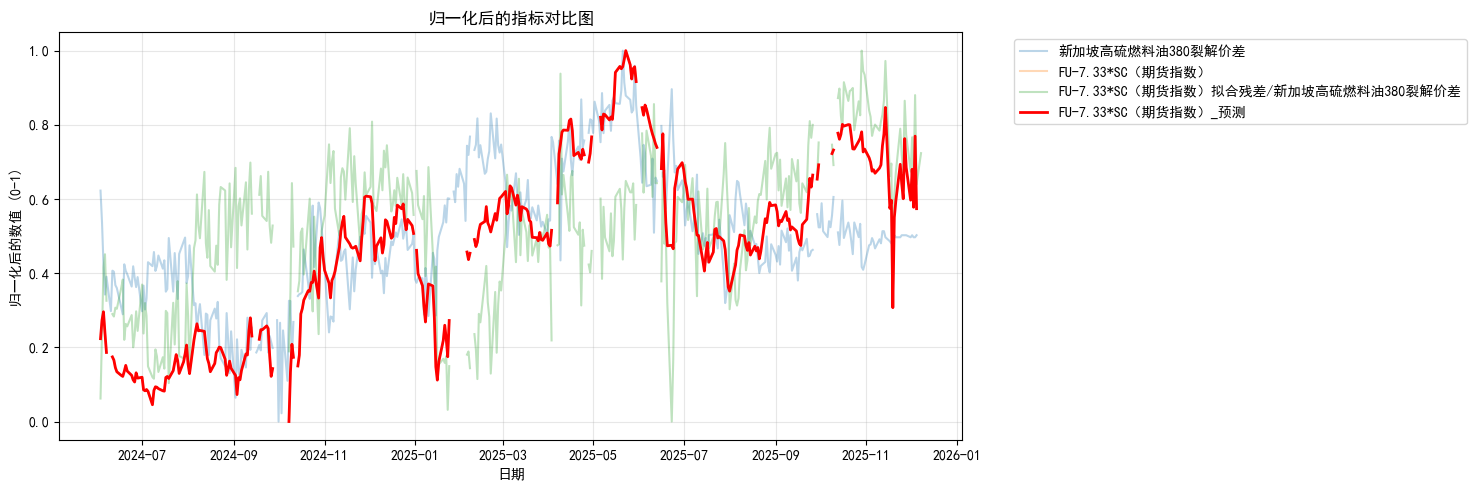

In [25]:
# 对数据进行归一化处理
from sklearn.preprocessing import MinMaxScaler

# 创建一个新的DataFrame来存储归一化后的数据
normalized_df = sheet_sum_clean.copy()

# 对'FU-7.33*SC（期货指数）'和'FU-7.33*SC（期货指数）_预测'进行统一归一化处理
scaler_fu_sc = MinMaxScaler()
fu_sc_columns = ['FU-7.33*SC（期货指数）', 'FU-7.33*SC（期货指数）_预测']
combined_data = pd.concat([sheet_sum_clean[fu_sc_columns[0]], sheet_sum_clean[fu_sc_columns[1]]])
normalized_values = scaler_fu_sc.fit_transform(combined_data.values.reshape(-1, 1))
normalized_df[fu_sc_columns[0]] = normalized_values[:len(sheet_sum_clean)]
normalized_df[fu_sc_columns[1]] = normalized_values[len(sheet_sum_clean):]

# 对其他列进行归一化处理
for col in sheet_sum_clean.columns:
    if col != 'Date' and col not in fu_sc_columns:
        scaler = MinMaxScaler()
        normalized_df[col] = scaler.fit_transform(sheet_sum_clean[col].values.reshape(-1, 1))


# 绘制归一化后的数据
plt.figure(figsize=(15, 5))

# 设置透明度
alpha_others = 0.3  
alpha_main = 1.0    

# 绘制每个指标
for col in normalized_df.columns:
    if col != 'Date':  
        if col == 'FU-7.33*SC（期货指数）_预测':
            plt.plot(normalized_df['Date'], normalized_df[col], 
                    label=col, 
                    color='red', 
                    linewidth=2,
                    alpha=alpha_main)
        else:
            plt.plot(normalized_df['Date'], normalized_df[col], 
                    label=col, 
                    alpha=alpha_others)

plt.title('归一化后的指标对比图')
plt.xlabel('日期')
plt.ylabel('归一化后的数值 (0-1)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



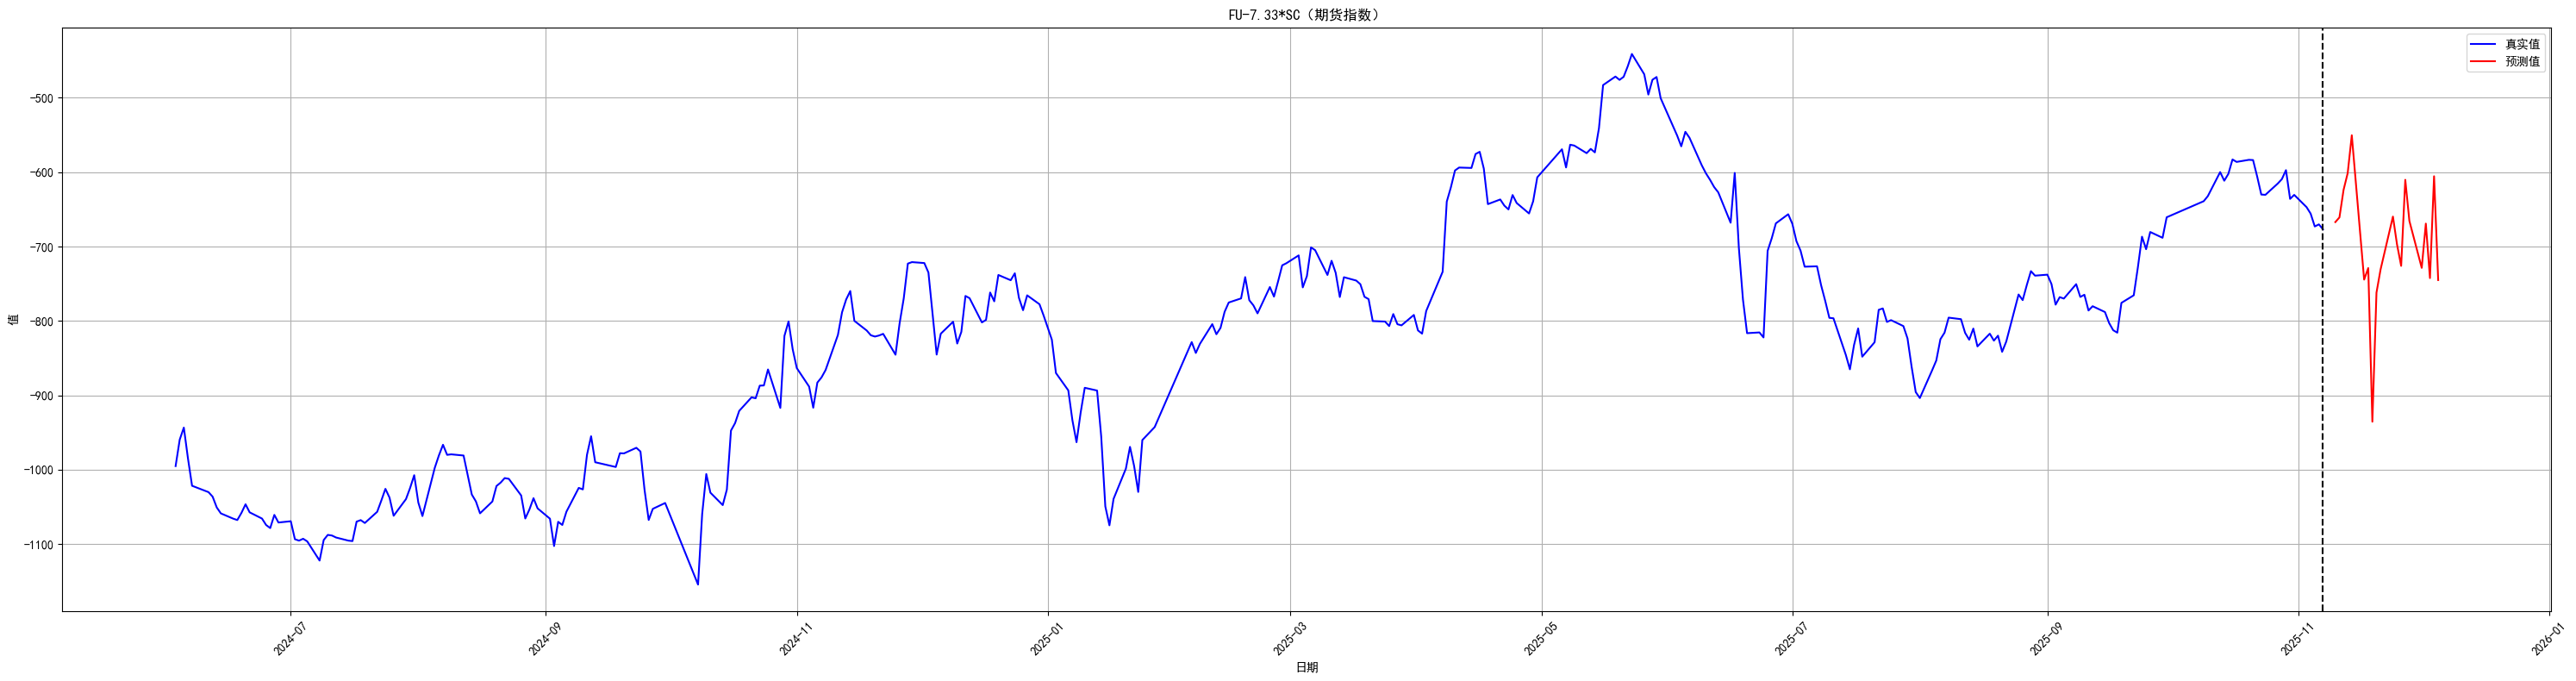

In [26]:
# 设置图形大小
plt.figure(figsize=(30, 8))
merged_df_daily_plot = merged_df_daily_sum
merged_df_daily_plot['Date'] = pd.to_datetime(merged_df_daily_plot['Date'])
plt.plot(merged_df_daily_plot['Date'], merged_df_daily_plot['FU-7.33*SC（期货指数）'], color='blue', label='真实值')
plt.plot(merged_df_daily_plot['Date'], merged_df_daily_plot['FU-7.33*SC（期货指数）_预测'], color='red', label='预测值')
avline_date = pd.to_datetime(last_day)
plt.axvline(x=avline_date, color='black', linestyle='--')
plt.legend()
plt.title('FU-7.33*SC（期货指数）')
plt.xlabel('日期')
plt.ylabel('值')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "FU-7.33*SC（期货指数）拟合残差/新加坡高硫燃料油380裂解价差"

# 调用函数更新数据
success = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [28]:
from Lcel import update_excel_data
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "详情页"
identifier = "FU-7.33*SC（期货指数）拟合残差/新加坡高硫燃料油380裂解价差"       # NEW: 新增日期标识符列的抬头
# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")


数据过滤完成: 保留 24 条数据（2024/01/31 之后），按时间倒序排列


已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/11/30, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件


In [29]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "FU-7.33*SC（期货指数）"

# 调用函数更新数据
success = update_excel_data(merged_df_daily_sum, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [30]:
from Lcel import update_excel_data
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "详情页"
identifier = "FU-7.33*SC（期货指数）"       # NEW: 新增日期标识符列的抬头
# 调用函数更新数据
success = update_excel_data(merged_df_monthly_sum, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")


数据过滤完成: 保留 19 条数据（2024/01/31 之后），按时间倒序排列


已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/11/30, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件
